# Setting up the environment

In [1]:
print("hi")

hi


In [2]:
%load_ext autoreload
%autoreload 2
import numpy
import pandas
import io
import uuid
import psycopg.sql
import pyarrow
import pyarrow.parquet
import os
import json
import paramiko
from tqdm import tqdm

import jobqueue
from jobqueue.connection_manager import ConnectionManager

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
from methods import *
import dmp.keras_interface.model_serialization as model_serialization
from dmp.task.experiment.training_experiment.training_epoch import TrainingEpoch

pd.options.display.max_seq_items = None

credentials = jobqueue.load_credentials("dmp")

from dataclasses import dataclass

@dataclass
class Column:
    name : str
    pandas_type : str



2024-05-20 10:06:23.088406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# def getWeights(runId, userName, weightName=None, saveDir="./tempWeights"):
#     # Define the location of the weights on the remote server
#     location = f"/projects/modularai/dmp/dmp/model_data/{runId}.h5"
#     # if the save directory doesn't exist, create it
#     os.makedirs(saveDir, exist_ok=True)

#     # If weightName is not provided, use runId as weightName
#     if weightName is None:
#         weightName = runId

#     # Define the list of HPC servers
#     hpclist = ["kestrel.hpc.nrel.gov"]
#         # It is all migrated to kestrel, "vermilion.hpc.nrel.gov", "eagle.hpc.nrel.gov"]

#     # Iterate through each HPC server
#     for hpc in hpclist:
#         command = f"scp {userName}@{hpc}:{location} {os.path.join(saveDir, f'{weightName}.h5')}"
#         print(command)
#         os.system(command)
    
#     return os.path.join(saveDir, f'{weightName}.h5')

# def flatten_json(json_obj, parent_key="", separator="_"):
#     flattened = {}
#     for key, value in json_obj.items():
#         new_key = f"{parent_key}{separator}{key}" if parent_key else key
#         if isinstance(value, dict):
#             flattened.update(flatten_json(value, new_key, separator=separator))
#         else:
#             flattened[new_key] = value
#     return flattened

# def loadWeights(fileName:str, history):
#     import h5py as h5
#     print("Loading weights")
#     file = h5.File(fileName, 'r')
#     epoch_dataset, parameter_dataset, optimizer_datasets = model_serialization.get_datasets_from_model_file(file, None)
#     epoch_data = epoch_dataset[:]
#     parameter_data = parameter_dataset[:]
#     optimizer_data = [opt[:] for opt in optimizer_datasets]  # Assuming optimizer_datasets is a list of datasets
#     file.close()

#     global_epoch = epoch_dataset[0, :]
#     fit_number = epoch_dataset[1, :]
#     fit_epoch = epoch_dataset[2, :]
#     epoch_marker = epoch_dataset[3, :]
#     print("sorting weights")
#     epochs = []
#     for i in range(epoch_dataset.shape[1]):
#         # TrainingEpoch is an object that contains the attributes 
#         epoch = TrainingEpoch(
#             global_epoch[i], fit_number[i], fit_epoch[i], epoch_marker[i]
#         )
#         retained =  history
#         if retained.loc[
#             (retained["epoch"] == epoch.epoch)
#             & (retained["fit_number"] == epoch.fit_number)
#             & (retained["fit_epoch"] == epoch.fit_epoch)
#         ].empty:
#             continue
#         epochs.append(
#             (
#                 epoch,
#                 i,
#             )
#         )
#     epochs.sort()
#     return epochs, parameter_data, optimizer_data
        
# # ========
# def runQuery(query:str):
#     """
    
#         Given a query, run the query and return the results as a pandas dataframe
#         input:
#             query: str
#                 The query to run
#     """
#     experiment_id = 0
#     run_command = {}
#     dataframes = []
    
#     os.makedirs("data_artifacts", exist_ok=True)
#     with ConnectionManager(credentials) as connection:
#         with connection.cursor(binary=True) as cursor:
#             cursor.execute(query, binary=True)

#             for row in cursor:
#                 row_data = []
#                 for column in row:
#                     row_data.append(column)
#                 dataframes.append(pd.DataFrame(row_data).T)      
                
#     history = pd.concat(dataframes, ignore_index=True, axis=0)
#     return history
    
# def getParentRuns(data:str = "lmc_mnist_lenet_4"):
#     """
#         Given an experiment, get the parent runs that are associated with the experiment
#         input:
#             data: str
#                 The name of the experiment
#         output: 
#             parentRuns: pd.DataFrame
#                 The dataframe containing the parent runs
#     """
#     query = f"""SELECT
#                 id
#             FROM
#                 run parent
#             WHERE TRUE
#                 AND command @@ '$."experiment"."type" == "LTHExperiment"' -- using 'jsonpath' expression to filter
#                 AND command @@ '$."config"."data"."batch" == "lmc_mnist_lenet_4"' -- using 'jsonpath' expression to filter
#                 AND status >= 2
#                 AND queue >= 0
#             """
#     fileName = f"./data_artifacts/parent_runs_{data}.csv"
#     if not os.path.exists(fileName):
#         parentRuns = runQuery(query)
#         parentRuns.columns = ['id']
        
#     if os.path.exists(fileName):
#         parentRuns = pd.read_csv(fileName)
        
#     return parentRuns

# def getExperiments(parentID:str, reDownload=False):
#     """
#         Given a parentID, get the experiments that are associated with the parentID
#         input: 
#             parentID: str
#                 The parentID to use to get the experiments

#         output:
#             experiments: pd.DataFrame
#                 The dataframe containing the experiments
#     """
#     query="""
#             SELECT
#             id,
#             command #> '{experiment,pruning,method,type}' pruning_method, 
#             command #> '{experiment,pruning,method,pruning_rate}' pruning_rate, 
#             command #> '{experiment,pruning,rewind_epoch,epoch}' rewind_epoch, 
#             command #> '{config,seed}' random_seed, 
#             experiment_id,
#             command,
#             history
#         FROM
#             run r
#         WHERE TRUE
#             AND command @> '{"experiment":{"type":"IterativePruningExperiment"}}'
#             AND (command #> '{experiment,pruning,method,pruning_rate}')::float >= 0.1
#             AND status >= 2
#             AND queue >= 0
#         """ + f"AND parent_id = '{parentID}';"
#     fileName = f"./data_artifacts/experiments_{parentID}.csv"
#     if os.path.exists(fileName):
#         experiments = pd.read_csv(fileName)
#         experiments['history'] = experiments['history'].apply(lambda x: pd.read_json(x))
        
#     if reDownload or not os.path.exists(fileName):
#         experiments = runQuery(query)
#         experiments.columns = ['id', 'pruning_method', 'pruning_rate', 'rewind_epoch', 'random_seed', 'experiment_id', 'command', 'history']

#         for row in experiments.iterrows():
#             run_command = row[1]['command']
#             from dmp.marshaling import marshal
#             run = marshal.demarshal(run_command)
#             flat = flatten_json(run_command)
#             # update the run command with the new values
#             row[1]['command'] = flat
            
#             history = row[1]['history']
#             data = []
#             with io.BytesIO(history) as buffer:
#                 history = pyarrow.parquet.read_table(pyarrow.PythonFile(buffer, mode="r")).to_pandas()
#                 data.append(history)
                
#             row[1]['history'] = pd.concat(data, ignore_index=True, axis=0)
#         # save as a csv
#         # experiments.to_csv(fileName, index=False)
        
 
#     for i, experiment in experiments.iterrows():
#         history = experiment['history']
#         history['prunedOut_percentage'] = history['free_parameter_count'] - history['masked_parameter_count']
#         experiments.at[i, 'history'] = history
        
#     return experiments

# # ======== 

# def extract_trajectories(parameter_dataset, parameter_indicies, epochs):
#     parameter_values = parameter_dataset[parameter_indicies, :]

#     trajectories = np.ndarray(shape=(len(parameter_indicies), len(epochs)))
#     for i, (epoch, sequence_number) in enumerate(epochs):
#         parameters_at_epoch = parameter_values[:, sequence_number]
#         trajectories[:, i] = parameters_at_epoch

#     return trajectories

# def getExperimentWeights(experiement:pd.Series, userName:str, retainedWeights:bool=True):
#     """
#         Given an experiment from getExperiments, get the experiment, the parameter dataset, and the optimizer datasets
#     """
#     import h5py as h5
    
#     print(f"processing: {experiement['id']}")
#     history = experiement.history
#     # where retained is true
#     retained = history[history['retained'] == retainedWeights]
#     filename = getWeights(experiement['id'], userName)
#     epochs, parameter_dataset, optimizer_datasets = loadWeights(filename, retained)
#     return epochs, parameter_dataset, optimizer_datasets



# Setting up the parentIDS and ChildIDs for a study.

In [4]:
#  step 1 get all parent runs
parentIDs = getParentRuns()

#  step 2 get a single child experiment
studyID = parentIDs['id'][0]

# step 3 get all the experiments
experiments = getExperiments(studyID)

# step 4 get a single experiment
experiment = experiments.iloc[0]

print(f"experiment set: {studyID}")
print(f"history of first experiment in the set:\n\n\n{experiment}")

experiment set: b6ff901e-5bca-45c8-aede-a40977c3e182
history of first experiment in the set:


id                             13d0cd8e-fc0d-4740-9b3a-8f47276aeb6b
pruning_method                                      MagnitudePruner
pruning_rate                                                   0.36
rewind_epoch                                                      2
random_seed                                              1705621052
experiment_id                  109bde9a-7a56-bcd5-2452-5ab1be846f50
command           {'type': 'Run', 'config_data_batch': 'lmc_mnis...
history                fit_number  epoch_startms_ms  free_parame...
Name: 0, dtype: object


# Checking for duplicates

In [5]:
# print all duplicates
duplicated = parentIDs[parentIDs.duplicated()]
print(f"number of duplicates are: {len(duplicated)}")


number of duplicates are: 0


## Checking for errors in the duplicates

In [6]:
studyID = parentIDs['id'][0]
print(f"Studying: {studyID}")
experiments = getExperiments(studyID)
print(experiments.iloc[0])
print("\n\n\n"+"==="*10)
study = experiments['history'].iloc[0]
print(f"Number of history epochs: {len(study)}")

print("\n\n\n"+"==="*10)
duplicated = experiments['experiment_id'][experiments['experiment_id'].duplicated()]
print(f"number of duplicates are: {len(duplicated)}")
print("\n")
if len(duplicated) > 0:
    for i in duplicated:
        print(f"Duplicate: {i}")

Studying: b6ff901e-5bca-45c8-aede-a40977c3e182
id                             13d0cd8e-fc0d-4740-9b3a-8f47276aeb6b
pruning_method                                      MagnitudePruner
pruning_rate                                                   0.36
rewind_epoch                                                      2
random_seed                                              1705621052
experiment_id                  109bde9a-7a56-bcd5-2452-5ab1be846f50
command           {'type': 'Run', 'config_data_batch': 'lmc_mnis...
history                fit_number  epoch_startms_ms  free_parame...
Name: 0, dtype: object



Number of history epochs: 214



number of duplicates are: 40


Duplicate: c17c9735-482c-8e3d-b4bb-0958a0b6b006
Duplicate: 58d5e461-3c2e-e518-7642-1509a16361d2
Duplicate: 200cd34b-7140-12e5-0831-afaf9dbc3174
Duplicate: 807cc637-2c9a-68f7-caf5-e285ef3a6fdf
Duplicate: 4d392ef8-7bb5-12ef-691a-8ce93521b383
Duplicate: 009be674-2f99-5de8-6eaa-3bf0e70b7318
Duplicate: b47aa7b8-9540-6f09-3

In [7]:
print(f"number of duplicated experiement id's = {len(duplicated)}")
for duplicate in duplicated:
    dup = experiments[experiments['experiment_id'] == duplicate]
    print(f"\tchecking experiment id: {duplicate}")
    for i in range(len(dup)):
        for j in range(len(dup)):
            if i != j:
                c1 = dup['command'].iloc[i]
                c2 = dup['command'].iloc[j]
                # print the difference
                diff = {k: [c1[k], c2[k]] for k in c1 if c1[k] != c2[k]}
                if len(diff) > 0:
                    for key, value in diff.items():
                        print(f"\t\tKey: {key}\n\t\t\tValue: {value}")
            if i == j:
                break

    print("==="*10)

number of duplicated experiement id's = 40
	checking experiment id: c17c9735-482c-8e3d-b4bb-0958a0b6b006
		Key: config_data_run_id_value
			Value: ['6f18ade0-594f-4745-82df-38475a9cfbfa', '31bdb324-74a5-491d-96b0-e948337a9987']
		Key: config_data_context_cpus
			Value: [[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]]
		Key: config_data_context_nodes
			Value: [[2, 3], [0, 1]]
		Key: config_data_context_worker_id_value
			Value: ['e6d36c3d-3174-4ae8-aa78-6ffb640938aa', '3c7fff3c-68e3-4973-907d-164d719d4ccf']
		Key: config_data_host_name
			Value: ['x1001c2s1b1n1', 'x1006c5s1b1n1']
		Key: config_data_slurm_job_id
			Value: [1116776, 1116767]
		Key: config_saved_models
			Value: [[{'type': 'TrainingEpoch', 'epoch': 0, 'marker': 0, 'fit_epoch': 0, 'fit_number': 0, 'sequence_number': 0}, {'type': 'TrainingEpoch', 'epoch': 1, 'marker': 0, '

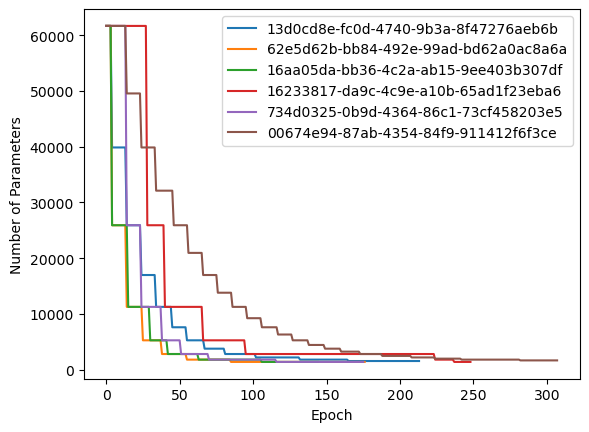

In [8]:
for i, experiement in experiments.iterrows():
    if i > 5:
        break
    plt.plot(experiement['history']['free_parameter_count'] - experiement['history']['masked_parameter_count'], 
             label=experiement['id'])
    plt.xlabel("Epoch")
    plt.ylabel("Number of Parameters")
plt.legend()
plt.show()

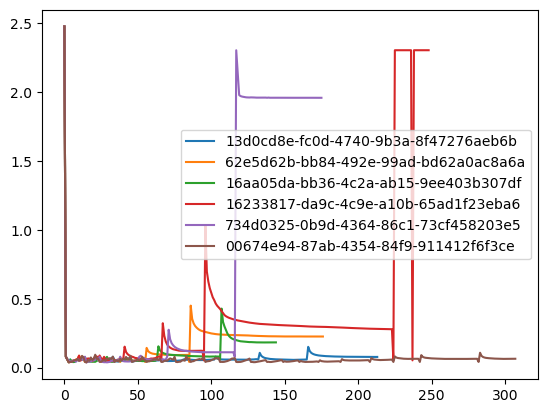

In [9]:
for i, experiement in experiments.iterrows():
    if i > 5:
        break
    plt.plot(experiement['history']['validation_loss'], 
             label=experiement['id'])
plt.legend()
plt.show()

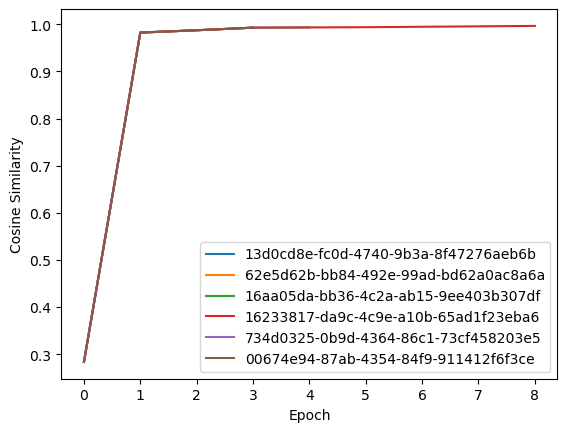

In [10]:
for i, experiement in experiments.iterrows():
    if i > 5:
        break
    plt.plot(experiement['history']['trained_cosine_similarity_extended'], 
             label=experiement['id'])
    plt.xlabel("Epoch")
    plt.ylabel("Cosine Similarity")
plt.legend()
plt.show()

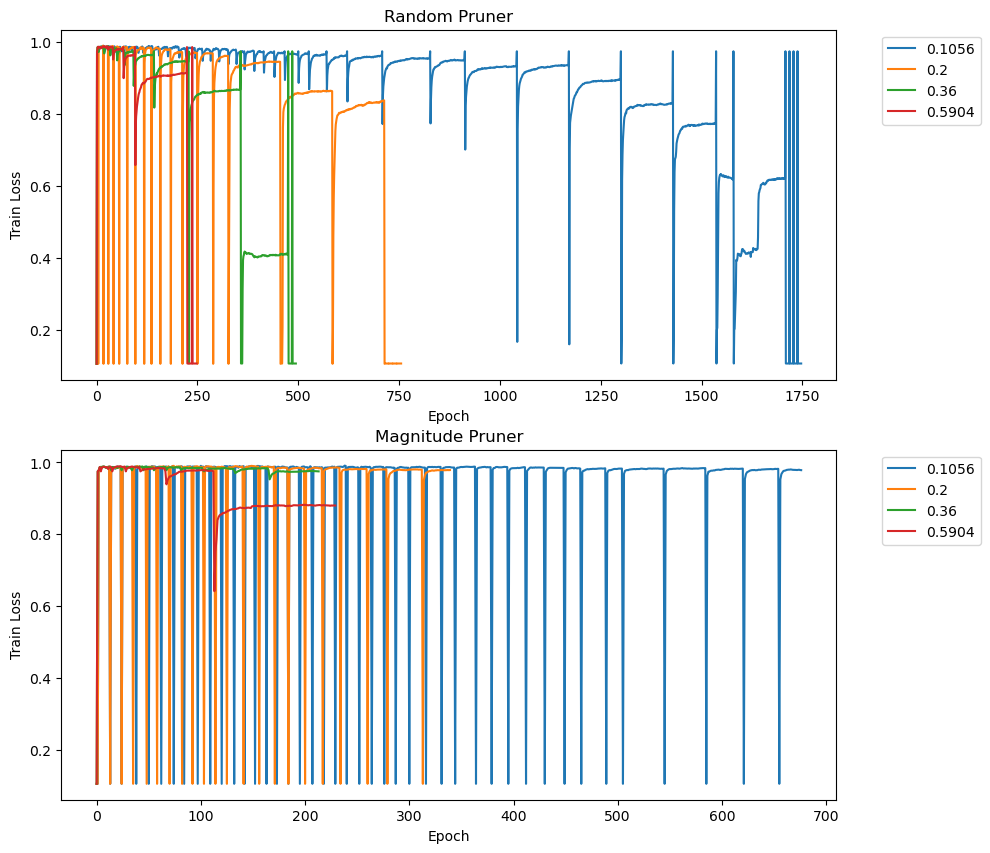

In [11]:
# make a 3x1 plot
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
Random_pruner = []
Magnitude_pruner = []
# sort the experiments by pruning rate
experiments = experiments.sort_values(by='pruning_rate')
for id, experiment in experiments.iterrows():
    history = experiment['history']
    plot = "validation_accuracy"
    if experiment['pruning_method'] == "RandomPruner":
        if not round(experiment['pruning_rate'],4) in Random_pruner:
            axs[0].plot(history[plot], label=round(experiment['pruning_rate'],4))
            Random_pruner.append(round(experiment['pruning_rate'],4))
    if experiment['pruning_method'] == "MagnitudePruner":
        if not round(experiment['pruning_rate'],4) in Magnitude_pruner:
            axs[1].plot(history[plot], label=round(experiment['pruning_rate'],4))
            Magnitude_pruner.append(round(experiment['pruning_rate'],4))

axs[0].set_xlabel("Epoch")
axs[1].set_xlabel("Epoch")
axs[0].set_ylabel("Train Loss")
axs[1].set_ylabel("Train Loss")
axs[0].set_title("Random Pruner")
axs[1].set_title("Magnitude Pruner")
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
        
        

# Plotting loss vs pruning rate

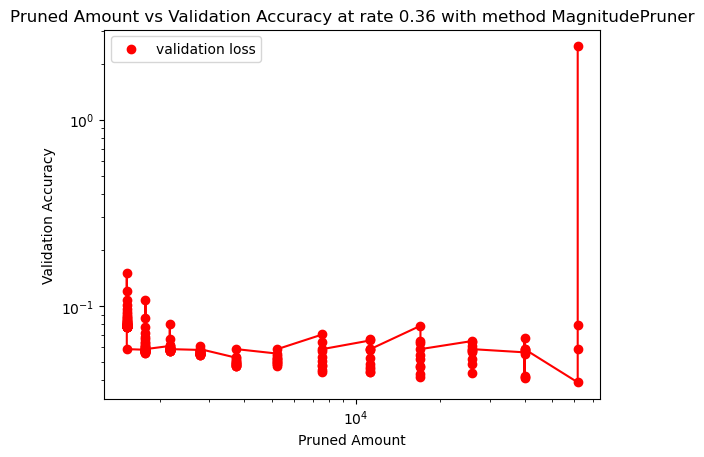

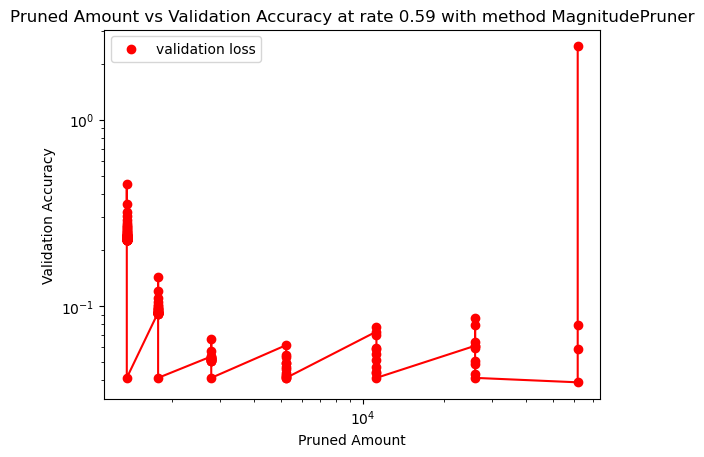

In [12]:
for i, experiment in getExperiments(getParentRuns()['id'][0]).iterrows():
    if i  > 1:
        break
    history = experiement.history
    # where retained is true
    retained = history[history['retained'] == True]
    #  we want to plot the best at each pruning iteration (i.e., test loss)
    # compare random and magnatude puning as in LMC paper based on Low and High rate
    plt.plot(experiment.history['prunedOut_percentage'], experiment.history['validation_loss'], color='red')
    plt.scatter(experiment.history['prunedOut_percentage'], experiment.history['validation_loss'],color='red', label="validation loss")
    
    plt.legend()
    plt.xlabel("Pruned Amount")
    plt.ylabel("Validation Accuracy")
    plt.title(f"Pruned Amount vs Validation Accuracy at rate {round(experiment['pruning_rate'], 3)} with method {experiment['pruning_method']}")
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

# Phase 2: comparing to LMC paper

In [13]:
#  step 1 get all parent runs
parentIDs = getParentRuns()

#  step 2 get a single child experiment
studyID = parentIDs['id'][0]

# step 3 get all the experiments
experiments = getExperiments(studyID)

id                             4cf0cdcc-41ca-4c02-8e2f-d274bfc17a25
pruning_method                                      MagnitudePruner
pruning_rate                                                   0.36
rewind_epoch                                                      0
random_seed                                              1705621052
experiment_id                  4d392ef8-7bb5-12ef-691a-8ce93521b383
command           {'type': 'Run', 'config_data_batch': 'lmc_mnis...
history                fit_number  epoch_startms_ms  free_parame...
Name: 6, dtype: object
processing: 54ccfbd4-b821-43ab-a455-ca4713e1b6fd
weights already downloaded
Loading weights
sorting weights


/Users/jgafur/Desktop/temp/BUTTER-Empirical-Deep-Learning-Experimental-Framework/example/methods.py:108: UserWarning: File needs to be closed
  warnings.warn("File needs to be closed")


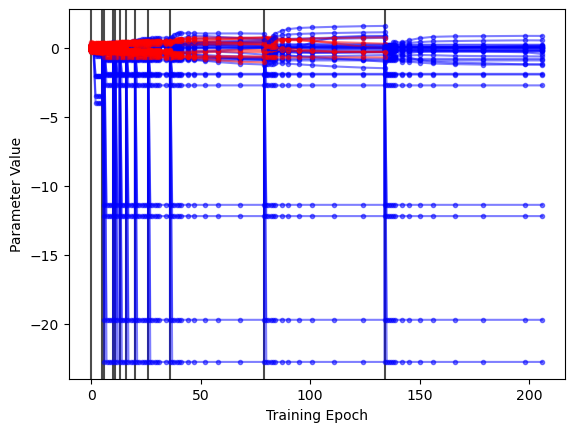

In [14]:
from methods import * 
experiment = experiments.iloc[10]
print(experiement)
epochs, parameter_dataset, optimizer_datasets, file = getExperimentWeights(experiment, "jgafur")

epoch_ranges = []
fit_number = None

for epoch, sequence_number in epochs:
    if len(epoch_ranges) == 0 or epoch_ranges[-1][-1][0].fit_number != epoch.fit_number:
        plt.axvline(x=epoch.epoch, color="k", alpha=0.7)
        epoch_ranges.append([])
        epoch_ranges[-1].append((epoch, sequence_number))
        
num_samples = 1000
num_samples = min(num_samples, parameter_dataset.shape[0])
parameter_indicies = np.random.choice(
    parameter_dataset.shape[0], replace=False, size=num_samples
)
parameter_indicies = list(np.sort(parameter_indicies))

trajectories = extract_trajectories(
    parameter_dataset, parameter_indicies, epochs
)


for i in range(trajectories.shape[0]):

    if np.isnan(trajectories[i, :]).any():
        plt.plot(
            [epoch.epoch for epoch, sequence_number in epochs],
            trajectories[i, :],
            ".-",
            alpha=0.5,
            color="red",
        )
    else:
        plt.plot(
            [epoch.epoch for epoch, sequence_number in epochs],
            trajectories[i, :],
            ".-",
            alpha=0.5,
            color="blue",
        )
  

plt.xlabel("Training Epoch")
plt.ylabel("Parameter Value")

plt.show()
file.close()

id                             4cf0cdcc-41ca-4c02-8e2f-d274bfc17a25
pruning_method                                      MagnitudePruner
pruning_rate                                                   0.36
rewind_epoch                                                      0
random_seed                                              1705621052
experiment_id                  4d392ef8-7bb5-12ef-691a-8ce93521b383
command           {'type': 'Run', 'config_data_batch': 'lmc_mnis...
history                fit_number  epoch_startms_ms  free_parame...
Name: 6, dtype: object
processing: 6f18ade0-594f-4745-82df-38475a9cfbfa
weights already downloaded
Loading weights
sorting weights


/Users/jgafur/Desktop/temp/BUTTER-Empirical-Deep-Learning-Experimental-Framework/example/methods.py:108: UserWarning: File needs to be closed
  warnings.warn("File needs to be closed")


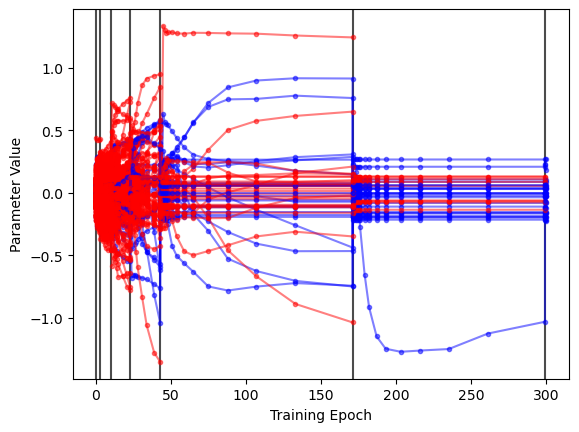

In [15]:
from methods import * 
experiment = experiments.iloc[8]
print(experiement)
epochs, parameter_dataset, optimizer_datasets, file = getExperimentWeights(experiment, "jgafur")

epoch_ranges = []
fit_number = None

for epoch, sequence_number in epochs:
    if len(epoch_ranges) == 0 or epoch_ranges[-1][-1][0].fit_number != epoch.fit_number:
        plt.axvline(x=epoch.epoch, color="k", alpha=0.7)
        epoch_ranges.append([])
        epoch_ranges[-1].append((epoch, sequence_number))
        
num_samples = 1000
num_samples = min(num_samples, parameter_dataset.shape[0])
parameter_indicies = np.random.choice(
    parameter_dataset.shape[0], replace=False, size=num_samples
)
parameter_indicies = list(np.sort(parameter_indicies))

trajectories = extract_trajectories(
    parameter_dataset, parameter_indicies, epochs
)


for i in range(trajectories.shape[0]):

    if np.isnan(trajectories[i, :]).any():
        plt.plot(
            [epoch.epoch for epoch, sequence_number in epochs],
            trajectories[i, :],
            ".-",
            alpha=0.5,
            color="red",
        )
    else:
        plt.plot(
            [epoch.epoch for epoch, sequence_number in epochs],
            trajectories[i, :],
            ".-",
            alpha=0.5,
            color="blue",
        )
  

plt.xlabel("Training Epoch")
plt.ylabel("Parameter Value")

plt.show()
file.close()